# Evaluation Report – MedMCQA (LoRA 4-bit)


## Mô hình
- **Model name**: LLaMA 3.2B 4bit LoRA
- **LoRA adapter**: QLoRA / PEFT
- **Tokenizer**: AutoTokenizer (LLaMA-compatible)
- **Fine-tune Framework**: `trl` + `SFTTrainer`

## Tham số huấn luyện
- `learning_rate`: 3e-4
- `lr_scheduler_type`: linear
- `batch_size`: 32
- `gradient_accumulation_steps`: 8
- `epochs`: 2
- `eval_steps`: 50
- `save_total_limit`: 1
- `optim`: adamw_8bit
- `fp16`: `True` / `False` (tùy GPU)


## Đánh giá mô hình (Accuracy & F1)

import thư viện

In [1]:
from transformers import logging
from peft import PeftModel
logging.set_verbosity_error()
from transformers import AutoModelForCausalLM, AutoTokenizer

import re
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset

f:\Parameter-Efficient-Fine-Tuning-For-ViMedMCQA\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load mô hình

In [2]:
model_path="dainlieu/Llama-3.2-3B-bnb-4bit-MedMCQA"

# Load base model (bnb-4bit)
base_model = AutoModelForCausalLM.from_pretrained(
    "unsloth/llama-3.2-3b-bnb-4bit",
    device_map="auto",               # cho dùng GPU
    load_in_4bit=True
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("unsloth/llama-3.2-3b-bnb-4bit")

# Load adapter (LoRA fine-tune)
model = PeftModel.from_pretrained(
    base_model,
    "dainlieu/Llama-3.2-3B-bnb-4bit-MedMCQA"
)

model.eval()

f:\Parameter-Efficient-Fine-Tuning-For-ViMedMCQA\venv\lib\site-packages\transformers\quantizers\auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.

Mẫu prompt và mapping

In [3]:
# Mẫu định dạng prompt đầu vào cho mô hình
data_prompt = """Question: {}
Choices:
{}
Answer"""

# Mapping chỉ số sang nhãn (ngược lại bạn có thể dùng trong đánh giá)
id2label = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

Hàm tạo prompt từ tập dữ liệu

In [37]:
def formatting_prompt(examples):
    """
    Tạo prompt theo định dạng chuẩn từ các cột dữ liệu đầu vào.
    Làm sạch câu hỏi bằng cách loại bỏ các ký tự không phải chữ/số hoặc khoảng trắng.
    Trả về danh sách prompt ở dạng {"text": [prompt1, prompt2, ...]}.
    """
    questions = examples["question"]
    opas = examples["opa"]
    opbs = examples["opb"]
    opcs = examples["opc"]
    opds = examples["opd"]

    texts = []
    for idx in range(len(questions)):
        # Làm sạch question: chỉ giữ lại chữ, số và khoảng trắng
        raw_question = questions[idx]
        question = ''.join(c for c in raw_question if c.isalnum() or c.isspace()).strip()

        choices = f"A. {opas[idx]}\nB. {opbs[idx]}\nC. {opcs[idx]}\nD. {opds[idx]}"
        prompt = data_prompt.format(question, choices)
        texts.append(prompt)

    return {"text": texts}

Hàm trích xuất đáp án từ mô hình (A/B/C/D → 0–3)

In [21]:
def extract_answer_index(text):
    """
    Trích xuất ký tự A/B/C/D sau 'Answer:' và chuyển thành chỉ số 0–3.
    Trả về -1 nếu không khớp.
    """
    match = re.search(r"Answer:\s*([ABCD])\b", text)
    if match:
        letter = match.group(1)
        return {'A': 0, 'B': 1, 'C': 2, 'D': 3}[letter]
    return -1

In [15]:
# Kiểm thử nhanh
test_cases = [
    "Answer: A",     # ✅ 0
    "Answer: B",     # ✅ 1
    "Answer: D",     # ✅ 3
    "Answer: C. Some explanation",  # ✅ 2
    "Answer: Z",     # ❌ -1
    "Nothing Bang",  # ❌ -1
]

for text in test_cases:
    print(f"{text} => {extract_answer_index(text)}")

Answer: A => 0
Answer: B => 1
Answer: D => 3
Answer: C. Some explanation => 2
Answer: Z => -1
Nothing Bang => -1


load dữ liệu

In [38]:
ds = load_dataset("openlifescienceai/medmcqa", split="validation")
ds_val = ds.map(formatting_prompt, batched=True)

Map: 100%|██████████| 4183/4183 [00:00<00:00, 30026.53 examples/s]


In [39]:
print(ds_val['text'][29])

Question: In a study two groups of newborns are checked for their weights based on whether their mothers received food supplements or not The appropriate test which can be used for comparing the data is
Choices:
A. Chi square test
B. Paired T-test
C. Student's T-test
D. Fischer exact test
Answer


thử dự đoán với 1 mẫu

In [40]:
inputs = tokenizer(ds_val['text'][29], return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=32,
    do_sample=False,
    pad_token_id=tokenizer.pad_token_id
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Question: In a study two groups of newborns are checked for their weights based on whether their mothers received food supplements or not The appropriate test which can be used for comparing the data is
Choices:
A. Chi square test
B. Paired T-test
C. Student's T-test
D. Fischer exact test
Answer:
The appropriate test which can be used for comparing the data is
Student's T-test

### Question:
A 40 year old male patient presents with a


Dự đoán với 100 mẫu

In [42]:
from tqdm import tqdm

res = []
ds_val500 = ds_val['text'][:300]

for i in tqdm(range(len(ds_val500)), desc="🔄 Đang sinh từng câu"):

    prompt = ds_val500[i]  # ✅ lấy từng câu riêng lẻ
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=32,
            do_sample=False,
        )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    res.append(extract_answer_index(answer))

🔄 Đang sinh từng câu: 100%|██████████| 300/300 [06:29<00:00,  1.30s/it]


🎯 Accuracy (hợp lệ): 43.11 %

⚠️ Mô hình trả về -1 (Không trả về đáp án) cho 17/300 mẫu (5.67%):  [17, 29, 39, 62, 103, 143, 145, 169, 186, 202, 207, 218, 221, 247, 266, 269, 281]

📋 Classification Report (chỉ mẫu hợp lệ):
              precision    recall  f1-score   support

           A       0.39      0.79      0.53        91
           B       0.51      0.26      0.34        74
           C       0.55      0.27      0.36        60
           D       0.44      0.26      0.33        58

    accuracy                           0.43       283
   macro avg       0.47      0.39      0.39       283
weighted avg       0.47      0.43      0.40       283



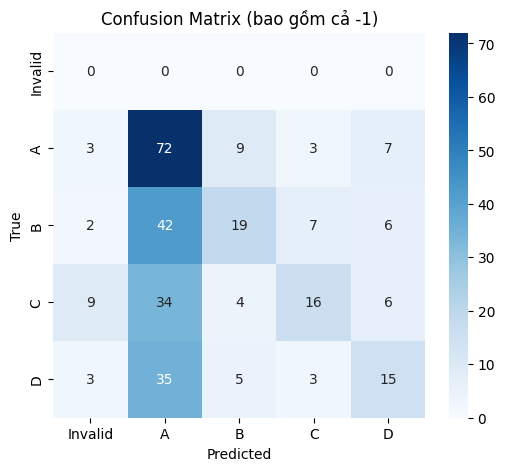

In [45]:
# ✅ Ground truth
gts = ds_val['cop'][:300] # Đảm bảo là list[int]
# ✅ res = [0, 1, 2, 3, -1, ...]  # đã có từ trước

# ✅ Tính accuracy (chỉ trên mẫu hợp lệ: 0–3)
valid_indices = []
invalid_indices = []

for i, r in enumerate(res):
    if r in [0, 1, 2, 3]:
        valid_indices.append(i)
    else:
        invalid_indices.append(i)
gts_valid = [gts[i] for i in valid_indices]
res_valid = [res[i] for i in valid_indices]

# 📌 Hugging Face Evaluate - Accuracy
accuracy = evaluate.load("accuracy")
acc_result = accuracy.compute(predictions=res_valid, references=gts_valid)
print("🎯 Accuracy (hợp lệ):", round(acc_result['accuracy'] * 100, 2), "%")

# ✅ Thống kê số mẫu invalid
num_invalid = len(invalid_indices)
print(f"\n⚠️ Mô hình trả về -1 (Không trả về đáp án) cho {num_invalid}/{len(res)} mẫu ({round(num_invalid/len(res)*100, 2)}%): ", invalid_indices)

# 📌 Classification Report (chỉ cho hợp lệ)
print("\n📋 Classification Report (chỉ mẫu hợp lệ):")
print(classification_report(gts_valid, res_valid, labels=[0,1,2,3], target_names=["A", "B", "C", "D"]))

# ✅ Mở rộng Confusion Matrix: gồm cả -1
labels_all = [-1, 0, 1, 2, 3]
target_names = ["Invalid", "A", "B", "C", "D"]

cm = confusion_matrix(gts, res, labels=labels_all)

# 📊 Vẽ heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_names,
            yticklabels=target_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (bao gồm cả -1)")
plt.show()